In [1]:
import numpy as np
from matplotlib import pyplot as plt 
import cv2

## Lab 3: Image clustering and superpixels

In this lab we are going to explore image clustering and superpixels segmentation. You will be required to complete the following tasks:

1. Implement k-means clustering to assign each pixel of an image to one of K distinct clusters, using colour similarity to determine assignment.
2. Modify your k-means clustering to find superpixels by assigning each pixel of the image to one of K distinct clusters, using both colour and location similarity to determine assignment.
3. Use superpixels to propose regions of interest in the image (we will learn about neural networks that use this information in week 11). 
4. Write a brief report (max 600 words) discussing explaining your implementation and results. Explain your reasoning by referencing the intermediate result figures you generated. 

You may use numpy and matplotlib and opencv for image loading.

### Academic integrity

Every lab submission will be screened for any collusion and/or plagiarism. Breaches of academic integrity will be investigated thoroughly and may result in a zero for the assessment along with interviews with the plagiarism officers at Monash University.

### Late submissions

The default late submission university penalty will apply.

### Lab Instructions and the Use of Generative AI

You may not use any built-in opencv functions for this lab, other than those used for loading/ saving an image, extracting and matching keypoints, and
computing homographies.
* You may use NumPy for array handling, and vectorizing your code (reducing
the number of for-loops) is encouraged.
* You should use Matplotlib to display images and any intermediate results.
* You may use generative AI.

### Grading
Each lab is worth 8%, and there are a number of sections and tasks with their own weighting. A task is only considered complete if you can demonstrate a working program and show an understanding of the underlying concepts. Note that later tasks should reuse code from earlier tasks.

Masks will be provided based on the correctness of the code, the quality of your results, comments indicating you understand your work, and a discussion of tasks provided at the end of the notebook. 

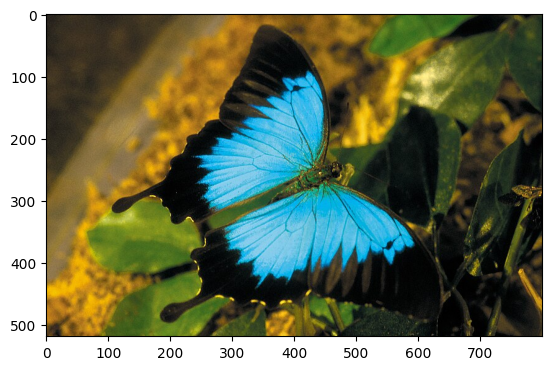

In [2]:
# Load and display image for testing
im = cv2.imread('CSIRO_ScienceImage_3831_Ulysses_Butterfly.jpg')/255.0
plt.imshow(im[:,:,[2,1,0]])
plt.show()

### Task 1: Implement K-means from first principles: colour similarity

Fill in the function below to implement the following steps. Your function should accept an image, a variable storing the number of iterations to repeat k-means for, the number of clusters K.
1. Flatten the image into an Nx3 vector of pixels (num pixels x r,g,b colour of pixel)
2. Select K random colour centroids
3. Repeat for n iterations:
   1. Assign each pixel in the vector to a cluster and store the index corresponding to this in a numpy array
   2. Update the centroid locations using the new cluster assignments
   3. Save the total loss at each iteration
4. Convert the cluster index array back into a 2D array the same size as the image, where each pixel contains the corresponding cluster index
5. Create a new quantised image, where each pixel is coloured according to the centroid corresponding to a given cluster index.
6. Return the loss, cluster index image and quantised image
7. Test your function on the sample image provided, and select an appropriate number of iterations 
8. Display the results for a number of choices of K. Use the returned losses to select an appropriate value for K 

In [66]:
def kmeans(im, iters=10, K=3, plot=False):
    
    # Kmeans is stochastic, so we will fix the seed of the random number generator to ensure each iteration starts with the same centroid initialisation
    seed = 42
    np.random.seed(seed)
       
    # Convert image into an Nx3 vector of pixels 
    img_shape = im.shape
    pixels = im.reshape(-1, 3)

    # Select K random colour centroids
    random_indices = np.random.choice(pixels.shape[0], size=K, replace=False)
    centroids = pixels[random_indices].astype(float)

    all_losses = []

    for j in range(iters):
        
        # Assign pixels to clusters
        distances = np.linalg.norm(pixels[:, np.newaxis] - centroids[np.newaxis, :], axis=2)  # (num_pixels, K)
        cluster_indices = np.argmin(distances, axis=1)
        
        # Update centroid locations using new cluster assignments
        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            if np.any(cluster_indices == k):  # Avoid division by zero
                new_centroids[k] = pixels[cluster_indices == k].mean(axis=0)
            else:  # If a cluster loses all its points, reinitialize randomly
                new_centroids[k] = pixels[np.random.choice(pixels.shape[0])]
        centroids = new_centroids
        
        # Store the current loss
        loss = np.sum((pixels - centroids[cluster_indices])**2)
        all_losses.append(loss)
        
        # Convert cluster indices to an image
        cluster_idx_image = cluster_indices.reshape(img_shape[0], img_shape[1])
    
        # Create a quantised image
        quantised_image_float_loop = centroids[cluster_indices].reshape(img_shape)
        quantised_image_scaled_loop = quantised_image_float_loop * 255.0
        quantised_image_clipped_loop = np.clip(quantised_image_scaled_loop, 0, 255)
        quantised_image_loop = quantised_image_clipped_loop.astype(np.uint8)

        
        # You may want to visualise the current progress of kmeans for debugging purposes
        if plot:
            plt.subplot(1,2,1)
            plt.imshow(cluster_idx_image)
            plt.title(f"Cluster Index Map (iter {j+1})")
            plt.subplot(1,2,2)
            plt.imshow(quantised_image_loop[:,:,[2,1,0]])
            plt.title(f"Quantised Image (iter {j+1})")
            plt.show()
        
    # Convert cluster indices to an image
    cluster_idx_image = cluster_indices.reshape(img_shape[0], img_shape[1])
    
    # Create a quantised image using the clustering
    quantised_image_float = centroids[cluster_indices].reshape(img_shape)   # Get centroid colors (float [0,1])
    quantised_image_scaled = quantised_image_float * 255.0                  # Scale back to [0, 255]
    quantised_image_clipped = np.clip(quantised_image_scaled, 0, 255)       # Clip
    quantised_image = quantised_image_clipped.astype(np.uint8)              # Convert to uint8
    
    return all_losses, cluster_idx_image, quantised_image 


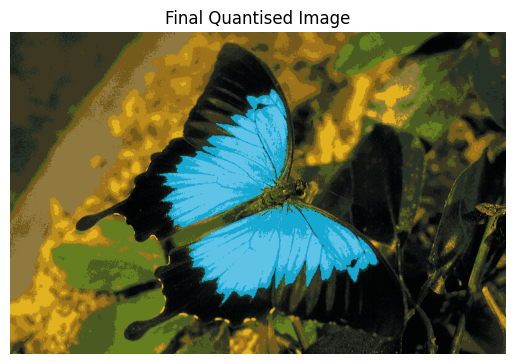

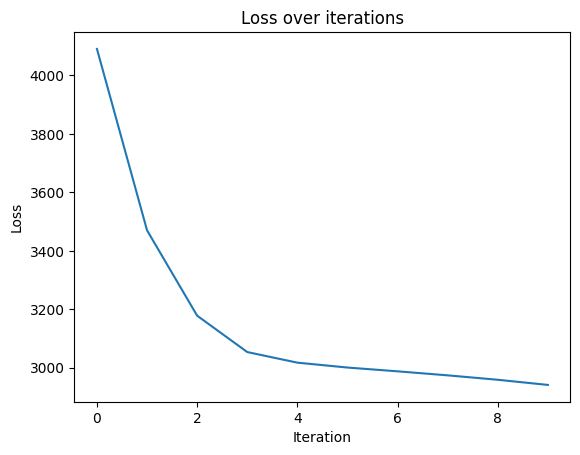

In [4]:
# Test your function using the image provided
losses, cluster_idx_img, quant_img = kmeans(im, iters=10, K=15, plot=False)

# Show final quantised image
plt.imshow(quant_img[:, :, [2, 1, 0]]) # Swap BGR -> RGB
plt.title("Final Quantised Image")
plt.axis('off')
plt.show()

# Plot loss over iterations
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()

Running KMeans with K=2...
Running KMeans with K=3...
Running KMeans with K=5...
Running KMeans with K=7...
Running KMeans with K=10...
Running KMeans with K=15...


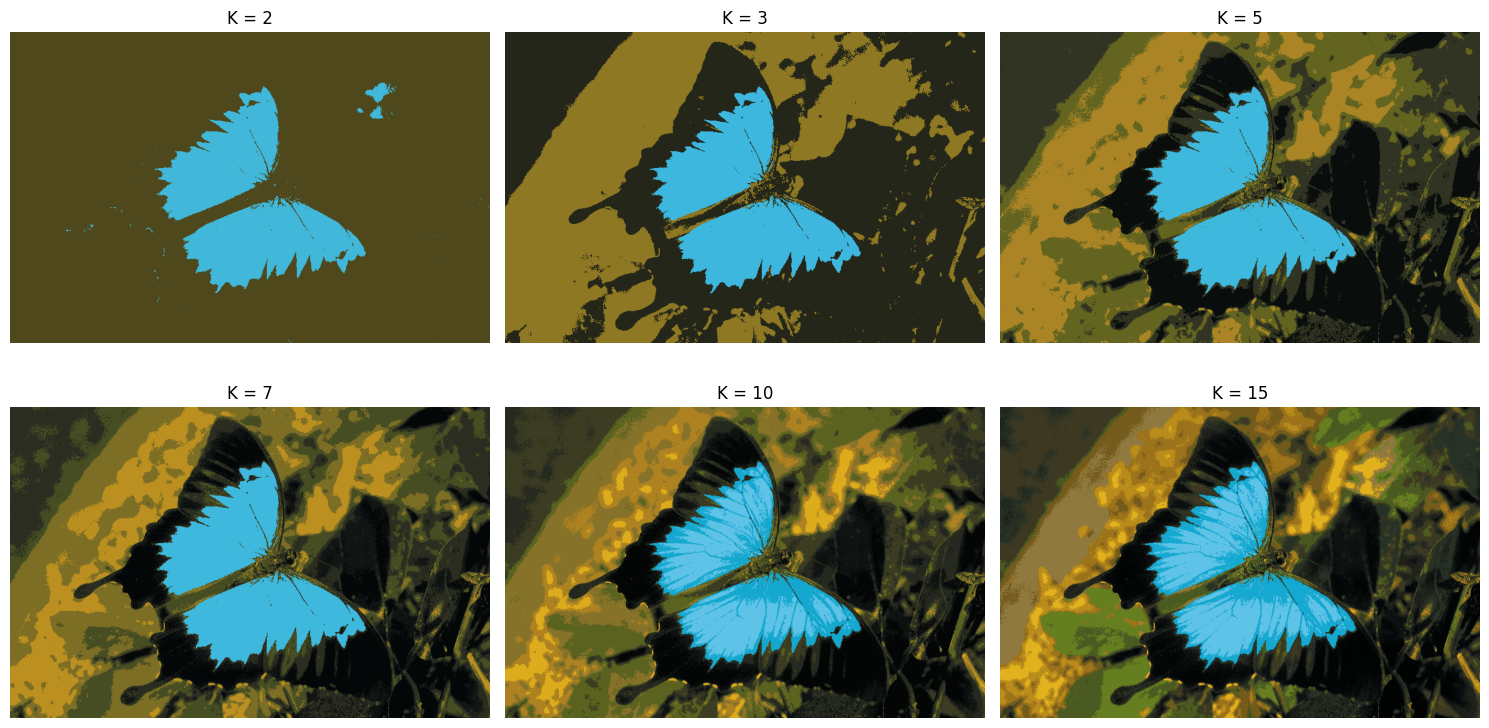

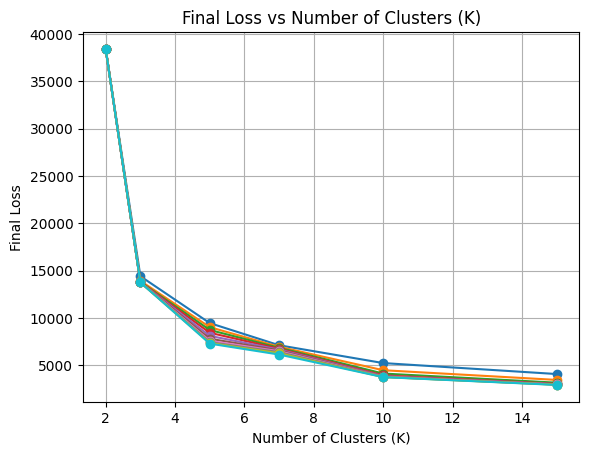

In [ ]:
# # Select an appropriate value for K and use visualisations to show how you did this
def test_k_values(im, k_values=[2,3,5,7,10,15], iters=10):
    all_losses = []

    plt.figure(figsize=(15, 8))
    for idx, K in enumerate(k_values):
        print(f"Running KMeans with K={K}...")
        loss, cluster_idx_img, quant_img = kmeans(im, iters=iters, K=K, plot=False)
        
        all_losses.append(loss)
        
        plt.subplot(2, 3, idx+1)
        plt.imshow(quant_img[:, :, [2,1,0]])  # Swap BGR to RGB
        plt.title(f"K = {K}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Plot losses
    plt.figure()
    plt.plot(k_values, all_losses, marker='o')
    plt.title('Final Loss vs Number of Clusters (K)')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Final Loss')
    plt.grid(True)
    plt.show()

test_k_values(im)

### Task 2: Modify K-means to cluster based on colour similarity and pixel location and extract superpixels

1. Modify the k_means function above to segment based on colour and pixel location, so that you extract superpixels.

2. Test your implementation by clustering the image into 50 superpixels.

3. Select an appropriate pixel coordinate scaling factor so that you trade-off incorporating colour information into the clustering, while ensuring superpixel continuity (all pixels in a superpixel must remain connected).

In [63]:
def kmeans_superpixel(im, iters=10, K=50, spatial_scale=100, plot=False):
    seed = 42
    np.random.seed(seed)
    
    img_shape = im.shape
    height, width = img_shape[:2]
    
    # Flatten the image to N x 3 (RGB)
    pixels = im.reshape(-1, 3)
    
    # Generate coordinate features
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    x_coords = x_coords.reshape(-1, 1) / spatial_scale
    y_coords = y_coords.reshape(-1, 1) / spatial_scale
    
    # Combine color and position features
    features = np.concatenate((pixels, x_coords, y_coords), axis=1)  # N x 5
    
    # Random initial centroids
    random_indices = np.random.choice(features.shape[0], size=K, replace=False)
    centroids = features[random_indices].astype(float)

    all_losses = []
    
    for j in range(iters):
        # Compute distances to centroids (in 5D space)
        distances = np.linalg.norm(features[:, np.newaxis] - centroids[np.newaxis, :], axis=2)
        cluster_indices = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            if np.any(cluster_indices == k):
                new_centroids[k] = features[cluster_indices == k].mean(axis=0)
            else:
                new_centroids[k] = features[np.random.choice(features.shape[0])]
        centroids = new_centroids
        
        loss = np.sum((features - centroids[cluster_indices])**2)
        all_losses.append(loss)

        if plot:
            cluster_img = cluster_indices.reshape(img_shape[:2])
            quant_rgb = centroids[cluster_indices][:, :3].reshape(img_shape)
            plt.subplot(1, 2, 1)
            plt.imshow(cluster_img)
            plt.title(f"Cluster Index (iter {j+1})")
            plt.subplot(1, 2, 2)
            plt.imshow(np.clip(quant_rgb[:, :, [2,1,0]], 0, 1))
            plt.title(f"Quantised Image (iter {j+1})")
            plt.show()

    cluster_idx_image = cluster_indices.reshape(img_shape[:2])
    quantised_image = (centroids[cluster_indices][:, :3].reshape(img_shape) * 255).astype(np.uint8)

    return all_losses, cluster_idx_image, quantised_image


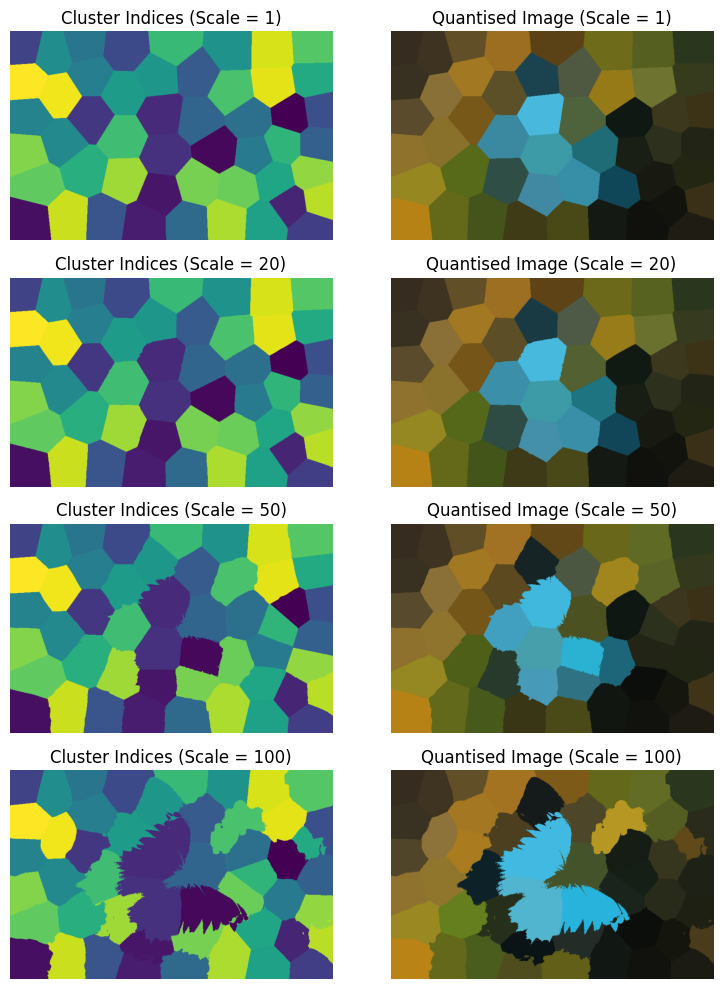

In [48]:
# Visualise your superpixel clustering for different scaling parameters 
scales = [1, 20, 50, 100]
fig, axs = plt.subplots(4, 2, figsize=(8, 10))

for i, scale in enumerate(scales):
    _, cluster_idx_img, quant_img = kmeans_superpixel(im, iters=10, K=50, spatial_scale=scale)

    # Cluster index map
    axs[i, 0].imshow(cluster_idx_img)
    axs[i, 0].set_title(f"Cluster Indices (Scale = {scale})")
    axs[i, 0].axis('off')

    # Quantised RGB image (BGR to RGB)
    axs[i, 1].imshow(quant_img[:, :, [2, 1, 0]])
    axs[i, 1].set_title(f"Quantised Image (Scale = {scale})")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

## Task 3: Region proposal

Segment your image into 10 superpixels. Then find the locations of the top left pixel and bottom right pixel in a superpixel, and use this information and the cv2.rectangle function to draw rectangles (regions) on the original image for each superpixel.


In [64]:
def kmeans_superpixel_normalised(im, iters=10, K=50, spatial_scale=100, plot=False):
    seed = 42
    np.random.seed(seed)
    
    img_shape = im.shape
    height, width = img_shape[:2]
    
    # Flatten the image to N x 3 (RGB)
    pixels = im.reshape(-1, 3)
    
    # Generate coordinate features
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    x_coords = x_coords.reshape(-1, 1) / spatial_scale
    y_coords = y_coords.reshape(-1, 1) / spatial_scale
    
    # Combine color and position features
    features = np.column_stack((x_coords.flatten() / spatial_scale,
                        y_coords.flatten() / spatial_scale,
                        pixels.reshape(-1, 3)))
    
    # Random initial centroids
    random_indices = np.random.choice(features.shape[0], size=K, replace=False)
    centroids = features[random_indices].astype(float)

    all_losses = []
    
    for j in range(iters):
        # Compute distances to centroids (in 5D space)
        distances = np.linalg.norm(features[:, np.newaxis] - centroids[np.newaxis, :], axis=2)
        cluster_indices = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            if np.any(cluster_indices == k):
                new_centroids[k] = features[cluster_indices == k].mean(axis=0)
            else:
                new_centroids[k] = features[np.random.choice(features.shape[0])]
        centroids = new_centroids
        
        loss = np.sum((features - centroids[cluster_indices])**2)
        all_losses.append(loss)

        if plot:
            cluster_img = cluster_indices.reshape(img_shape[:2])
            quant_rgb = centroids[cluster_indices][:, :3].reshape(img_shape)
            plt.subplot(1, 2, 1)
            plt.imshow(cluster_img)
            plt.title(f"Cluster Index (iter {j+1})")
            plt.subplot(1, 2, 2)
            plt.imshow(np.clip(quant_rgb[:, :, [2,1,0]], 0, 1))
            plt.title(f"Quantised Image (iter {j+1})")
            plt.show()

    cluster_idx_image = cluster_indices.reshape(img_shape[:2])
    quantised_image = (centroids[cluster_indices][:, :3].reshape(img_shape) * 255).astype(np.uint8)

    return all_losses, cluster_idx_image, quantised_image


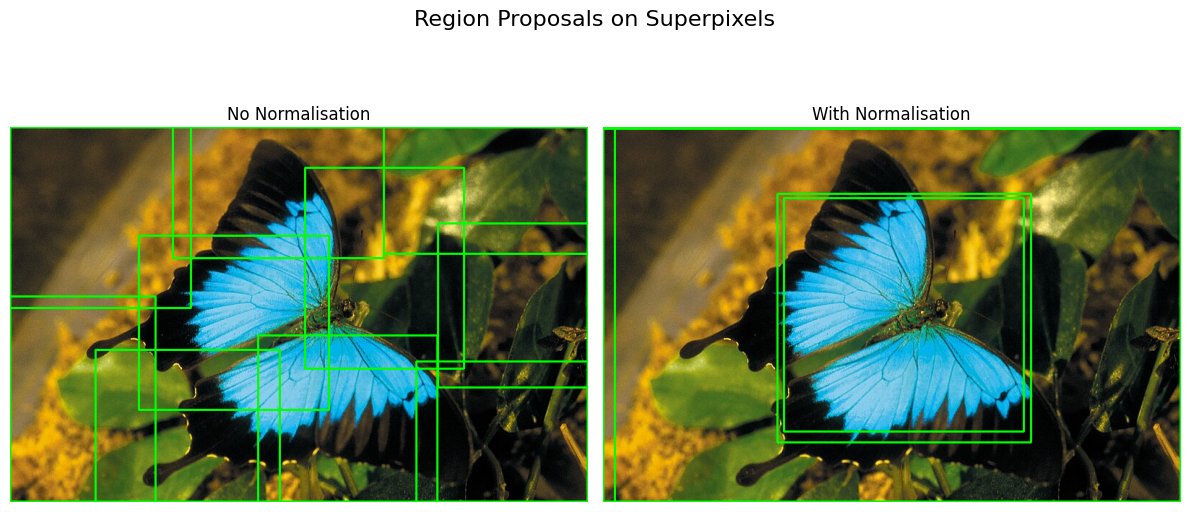

In [65]:
# Step 1: Segment without normalisation
losses, cluster_idx_img, quant_img = kmeans_superpixel(im, iters=30, K=10, spatial_scale=100)
original_image_unnorm = (im * 255).astype(np.uint8).copy()

for label in range(10):
    ys, xs = np.where(cluster_idx_img == label)
    if len(xs) == 0 or len(ys) == 0:
        continue
    top_left = (np.min(xs), np.min(ys))
    bottom_right = (np.max(xs), np.max(ys))
    cv2.rectangle(original_image_unnorm, top_left, bottom_right, color=(0, 255, 0), thickness=2)

# Step 2: Segment with normalisation
losses, cluster_idx_img, quant_img = kmeans_superpixel_normalised(im, iters=30, K=10, spatial_scale=100)
original_image_norm = (im * 255).astype(np.uint8).copy()

for label in range(10):
    ys, xs = np.where(cluster_idx_img == label)
    if len(xs) == 0 or len(ys) == 0:
        continue
    top_left = (np.min(xs), np.min(ys))
    bottom_right = (np.max(xs), np.max(ys))
    cv2.rectangle(original_image_norm, top_left, bottom_right, color=(0, 255, 0), thickness=2)

# Step 3: Display side-by-side using subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(original_image_unnorm[:, :, [2, 1, 0]])  # BGR to RGB
axes[0].set_title("No Normalisation")
axes[0].axis('off')

axes[1].imshow(original_image_norm[:, :, [2, 1, 0]])  # BGR to RGB
axes[1].set_title("With Normalisation")
axes[1].axis('off')

plt.suptitle("Region Proposals on Superpixels", fontsize=16)
plt.tight_layout()
plt.show()


## Task 4: Discussion

Write a brief report (max 600 words) discussing explaining your implementation
and results. Explain your reasoning by referencing the intermediate result figures
you generated.


The purpose of this lab was to implement and analyse superpixel segmentation and region proposal through modified K-means clustering using both spacial and colour features. 

In Task 1 I implemented K-Means segmentation using the skeleton code provided. The algorithm segmented the image based on RGB pixel values and grouped pixels into K clusters. Increasing K led to the algorithm having more segments by allowing it to represent more colour variation. As shown in task 1.2, using k = 2, the image was reduced to its two most dominant colours, blue and brown, producing a highly simplified result. As K increased the segmentation became more faithful to the original image. At K = 15, the result balanced simplicity and visual fidelity. However, a key limitation of colour-only K-means was its disregard for spatial coherence, clusters were often disjointed and scattered, grouping distant pixels of similar colour.

To further understand this I plotted the loss (mean squared distance between each pixel and its assigned cluster centre) for each value of K. As K increases the loss decreases allowing the model to approximate the pixel distribution better. However, this came with diminishing returns after around K = 20, the rate of improvement flattened, indicating that additional clusters offered marginal visual benefit. Smaller K values underfit the image by overgeneralising, while large K values overfit, fragmenting meaningful regions into overly fine detail.

In Task 2 I modified my code to include special features. Each pixel was represented as a 5D vector: [x/scale, y/ scale, R, G, B].
The spatial_scale parameter controlled the influence of spatial coordinates relative to colour values. A small spatial scale favoured spatial compactness (resulting in blocky, grid-like superpixels), while a larger scale prioritised colour similarity, often producing scattered clusters.
I experimented with a range of K values, the most visually coherent superpixels emerged with a spatial scale between 50-100, where clusters were both colour-similar and spatially local.

For Task 3, I used K = 10 to generate coarse regions for the object proposal. For each superpixel, the code computed the bounding rectangle by locating its top-left and bottom-right pixels. These were overlaid using cv2.rectangle to visualise region proposals on the original image. The bounding boxes captured major areas of interest, including parts of the butterfly and background segments. However, with only 10 clusters, each region was necessarily coarse. Some boxes overlapped or included background noise due to the large size of each superpixel and their mixed content.

I found that varying spatial_scale had limited effect on region shape, this suggested that spatial features were not strongly influencing clustering. I tried proper normalisation and the spatial terms became negligible compared to RGB values. This highlighted the importance of feature scaling in multimodal clustering.

Overall this lab highlighted the strengths and limitations of K-means for image segmentation. Colour-only clustering is simple and intuitive, it lacks spatial awareness. Incorporating pixel coordinates allows the creation of compact, connected superpixels are crucial for tasks like object detection.

Parameter tuning, especially for spatial_scale and K was essential to achieving useful results. This lab also gave me a good understanding of feature scaling, convergence behaviour, and trade-offs between detail and generalisation. Overall the extended K-means approach offered a strong baseline for superpixel-based region proposals, forming a bridge between raw pixels and higher-level vision algorithms.